# Kaggle Titanic survival - Random Forest Receiver Operator Characteristic (ROC) curve and balancing of model classification

In this model we combine two methods we previously examined in the logistic regression model.

We adjust classification probability cut-off to build a Receiver Operator Characteristic (ROC) curve, as described at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/06_roc_sensitivity_specificity.ipynb

And we use the same adjustment to look at balancing classification so that the predicted rate is the same as the observed survival rate. We will use multiple accuracy measurements, as used at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/15_imbalanced%20_data_threshold.ipynb

For both of this experiment we use stratified k-fold validation, as described at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/03_k_fold.ipynb

We swap out the logistic regression model for a Random Forest model (using default settings) as described at:

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/17_random_forest.ipynb

As all of these components have been previously described, we'll keep comments to a minimum.

In [ ]:
# Hide warnings (to keep notebook tidy; do not usually do this)
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold

## Download data if not previously downloaded

In [3]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Define function to calculate accuracy measurements

In [4]:
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

## Load data

In [5]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)
data.drop('PassengerId', inplace=True, axis=1)
X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'
# Convert to NumPy as required for k-fold splits
X_np = X.values
y_np = y.values

## Run model and collect results

In [6]:
# Set up k-fold training/test splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X_np, y_np)

# Set up thresholds
thresholds = np.arange(0, 1.01, 0.01)

# Create arrays for overall results (rows=threshold, columns=k fold replicate)
results_accuracy = np.zeros((len(thresholds),number_of_splits))
results_precision = np.zeros((len(thresholds),number_of_splits))
results_recall = np.zeros((len(thresholds),number_of_splits))
results_f1 = np.zeros((len(thresholds),number_of_splits))
results_predicted_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_observed_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_true_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_false_positive_rate = np.zeros((len(thresholds),number_of_splits))
results_auc = []

# Loop through the k-fold splits
loop_index = 0
for train_index, test_index in skf.split(X_np, y_np):
    
    # Create lists for k-fold results
    threshold_accuracy = []
    threshold_precision = []
    threshold_recall = []
    threshold_f1 = []
    threshold_predicted_positive_rate = []
    threshold_observed_positive_rate = []
    threshold_true_positive_rate = []
    threshold_false_positive_rate = []

    # Get X and Y train/test
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]

    # Set up and fit model (n_jobs=-1 uses all cores on a computer)
    model = RandomForestClassifier(n_jobs=-1)
    model.fit(X_train,y_train)
    
    # Get probability of non-survive and survive
    probabilities = model.predict_proba(X_test)
    # Take just the survival probabilities (column 1)
    probability_survival = probabilities[:,1]
    
    # Loop through increments in probability of survival
    for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
        # Get whether passengers survive using cutoff
        predicted_survived = probability_survival >= cutoff
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_survived)
        # Add accuracy scores to lists
        threshold_accuracy.append(accuracy['accuracy'])
        threshold_precision.append(accuracy['precision'])
        threshold_recall.append(accuracy['recall'])
        threshold_f1.append(accuracy['f1'])
        threshold_predicted_positive_rate.append(
                accuracy['predicted_positive_rate'])
        threshold_observed_positive_rate.append(
                accuracy['observed_positive_rate'])
        threshold_true_positive_rate.append(accuracy['true_positive_rate'])
        threshold_false_positive_rate.append(accuracy['false_positive_rate'])
    
    # Add results to results arrays
    results_accuracy[:,loop_index] = threshold_accuracy
    results_precision[:, loop_index] = threshold_precision
    results_recall[:, loop_index] = threshold_recall
    results_f1[:, loop_index] = threshold_f1
    results_predicted_positive_rate[:, loop_index] = \
        threshold_predicted_positive_rate
    results_observed_positive_rate[:, loop_index] = \
        threshold_observed_positive_rate
    results_true_positive_rate[:, loop_index] = threshold_true_positive_rate
    results_false_positive_rate[:, loop_index] = threshold_false_positive_rate
    
    # Calculate ROC AUC
    roc_auc = auc(threshold_false_positive_rate, threshold_true_positive_rate)
    results_auc.append(roc_auc)
    
    # Increment loop index
    loop_index += 1
    

# Transfer summary results to dataframe
results = pd.DataFrame(thresholds, columns=['thresholds'])
results['accuracy'] = results_accuracy.mean(axis=1)
results['precision'] = results_precision.mean(axis=1)
results['recall'] = results_recall.mean(axis=1)
results['f1'] = results_f1.mean(axis=1)
results['predicted_positive_rate'] = \
    results_predicted_positive_rate.mean(axis=1)
results['observed_positive_rate'] = \
    results_observed_positive_rate.mean(axis=1)
results['true_positive_rate'] = results_true_positive_rate.mean(axis=1)
results['false_positive_rate'] = results_false_positive_rate.mean(axis=1)
results['roc_auc'] = np.mean(results_auc)

mean_auc = np.mean(results_auc)
mean_auc = np.round(mean_auc, 3)

## Plot ROC curve

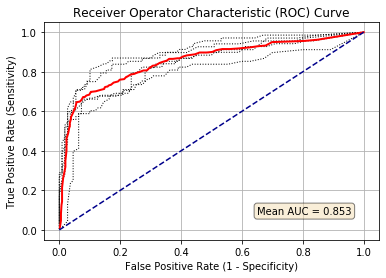

In [7]:
for i in range(number_of_splits):
    plt.plot(results_false_positive_rate[:, i],
             results_true_positive_rate[:, i],
             color='black',
             linestyle=':',
             linewidth=1)
plt.plot(results_false_positive_rate.mean(axis=1),
         results_true_positive_rate.mean(axis=1),
         color='red',
         linestyle='-',
         linewidth=2)
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operator Characteristic (ROC) Curve')
plt.grid(True)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
text = "Mean AUC = " + str(mean_auc)
plt.text(0.65, 0.08, text, bbox=props)
plt.show()

## Plot effects of changing classification probability threshold

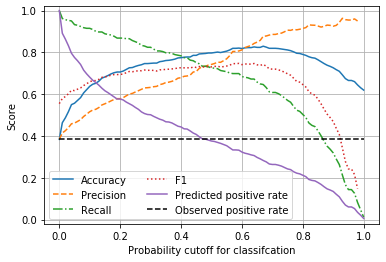

In [8]:
chart_x = results['thresholds']

plt.plot(chart_x, results['accuracy'],
         linestyle = '-',
         label = 'Accuracy')

plt.plot(chart_x, results['precision'],
         linestyle = '--',
         label = 'Precision')

plt.plot(chart_x, results['recall'],
         linestyle = '-.',
         label = 'Recall')

plt.plot(chart_x, results['f1'],
         linestyle = ':',
         label = 'F1')

plt.plot(chart_x, results['predicted_positive_rate'],
         linestyle = '-',
         label = 'Predicted positive rate')

plt.plot(chart_x, results['observed_positive_rate'],
         linestyle = '--',
         color='k',
         label = 'Observed positive rate')


plt.xlabel('Probability cutoff for classifcation')
plt.ylabel('Score')
plt.ylim(-0.02, 1.02)
plt.legend(loc='lower left', ncol=2)
plt.grid(True)

plt.show()

## Observations

* The Random Forest model, with default settings, has an ROC AUC of 0.85.
* Unlike the logistic regression model, the default probability threshold of 0.5 produces a balanced model, where precision = recall, and where the predicted survival rate is the same as the observed survival rate.
* If needed, the probability threshold of the Random Forest model could be adjust to change the model characteristics, such as for use in screening where recall (the detection of true positives) needs to be minimised at the accepted cost of lower precision (the detection of true negatives). In a screening situation false positives are generally accepted (as they will be eliminated later), but false negatives (where a condition is missed in screening) is much less acceptable.
* You will see that many aspects of machine learning models are directly transferable between model types.